In [1]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm

import seaborn as sns
import matplotlib as mpl
mpl.style.use('default')

#for simple fitting
import scipy.integrate as spi

%matplotlib inline


In [2]:
#define some constant names
celltypes=['TN', 'TSCM','TCM', 'TTM','TEM'] #cell type names

monolix_state_names=['T10_SAEM','T20_SAEM','T30_SAEM','T40_SAEM','T50_SAEM']
monolix_param_names=['th1_SAEM','th2_SAEM','th3_SAEM','th4_SAEM','th5_SAEM']

cellcolors=['deepskyblue','green','gold','orange','crimson']
cellnames=['$\mathrm{T_N}$','$\mathrm{T_{SCM}}$','$\mathrm{T_{CM}}$','$\mathrm{T_{TM}}$','$\mathrm{T_{EM}}$']

#info for monolix model
mname='modeling5corrected_subfrac_nodiff'
param_df=pd.read_csv('../monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')
poppm_df=pd.read_csv('../monolix/'+mname+'/populationParameters.txt')


In [3]:
## read in and manipulate several data sets

long_df=pd.read_csv('data/long_df.csv')
long_df_wtot=pd.read_csv('data/long_df_wtot.csv')

more_correlates=pd.read_csv('data/more_correlates.csv')
more_correlates['id']=more_correlates['HOPE ID'] #to make the merge easier

#update all correlates further

corrdl1 = []

lct_names=''
for ip,p in enumerate(long_df['pat_id'].unique()):
    lct=[]
    lct_names=[]
    for ic,ct in enumerate(celltypes):
    
        tdf=long_df[(long_df['pat_id']==p) & (long_df['celltype']==ct)]
    
        tpre, TRECs, Gini, Age, chl, IL7, IL15 = tdf[['preART_months','TRECs','GiniInd','Age_years','cellular_hl_days','IL7','IL15']].iloc[0].values

        lct.append(chl)
        lct.append(Gini)
        lct_names.append(ct+'_hl')
        lct_names.append(ct+'_G')
    
    #tdf2=long_df_wtot[(long_df_wtot['celltype']=='total') & (long_df_wtot['pat_id']==p)]
    corrdl1.append([p,tpre, TRECs,Age,IL7,IL15]+lct)
        
corr1 = pd.DataFrame(corrdl1,columns=['id','preARTmo','TRECs','Age','IL7','IL15']+lct_names)

more_correlates = pd.merge(more_correlates,corr1)

#merge to make the correlation between params and clinical vars
clincorr_df = pd.merge(more_correlates,param_df[monolix_param_names+['id']])



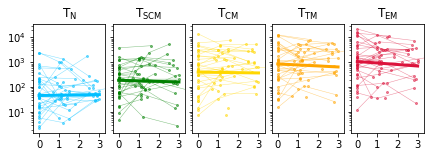

In [4]:
#plot all subset data relative to study initiation

fig,axarr=plt.subplots(1,5,figsize=(7,2),sharex=True,sharey=True)
sim_t = np.linspace(0,3,100)
for ic,ct in enumerate(celltypes):
    ax=axarr[ic]
    for ip,p in enumerate(long_df['pat_id'].unique()):
        tdf=long_df[(long_df['pat_id']==p) & (long_df['celltype']==ct)]
        ax.semilogy(tdf['time_postART_years']-tdf['time_postART_years'].iloc[0],tdf['DNApmsub'],
                    ls='-',marker='o',lw=0.5,markersize=2,alpha=0.5,color=cellcolors[ic])#cz_list[pind])

    avgT0 = np.median(param_df['T'+str(ic+1)+'0_mode'])
    avg_k = np.median(param_df['th'+str(ic+1)+'_mode'])
    ax.plot(sim_t,avgT0*np.exp(avg_k*sim_t),lw=3,color=cellcolors[ic])
        
    ax.set_title(cellnames[ic])

#axarr[2].set_xlabel('Time (study years)')
#axarr[0].set_ylabel('Subset infection fraction \n (HIV DNA per mil subset cells)')
axarr[0].set_xticks(range(5))
axarr[0].set_xlim([-0.3,3.3])
plt.subplots_adjust(wspace=0.1)

#plt.tight_layout()    
plt.savefig('figures/subfrac_studyyears.pdf',dpi=600)

Ttest_1sampResult(statistic=0.9773702087309007, pvalue=0.3349084153084989)
Ttest_1sampResult(statistic=-1.8077356342079844, pvalue=0.07900912392427721)
Ttest_1sampResult(statistic=0.07680329695445262, pvalue=0.9392052955098034)
Ttest_1sampResult(statistic=-6.871982971740201, pvalue=4.835463209325632e-08)
Ttest_1sampResult(statistic=-9.020900902833906, pvalue=9.044070851823167e-11)


/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


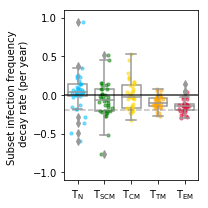

In [5]:
#look at net clearance rates w t-test
plt.figure(figsize=(3,3))
jit=0.1
for i in range(5):
    plt.scatter(np.random.normal(i,jit,len(param_df)),param_df[monolix_param_names[i]],s=10,color=cellcolors[i],alpha=0.5)
    print(st.ttest_1samp(param_df[monolix_param_names[i]],popmean=0))

sns.boxplot(param_df[monolix_param_names],width=0.7,color='white')
plt.axhline(0,color='k',alpha=0.8)
plt.axhline(-0.2,color='gray',ls='--',alpha=0.5)
plt.xlim([-.5,4.5])
plt.xticks(range(5),cellnames)
#plt.xticks(range(1,7),celltypes)
plt.ylabel('Subset infection frequency \n decay rate (per year)')
plt.ylim([-1.1,1.1])
plt.tight_layout()

plt.savefig('figures/subfrac_rates_box3.pdf',dpi=600)


In [6]:
#use z-test for population parameters

poppm_df['Z']=poppm_df['value']/poppm_df['se_sa']
poppm_df['pval'] = st.norm.sf(np.abs(poppm_df['Z']))

poppm_df.iloc[5:10,:]

/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,parameter,value,se_sa,rse_sa,Z,pval
5,th1_pop,0.028100,0.120142,427.553363,0.233889,0.407536
6,th2_pop,-0.064846,0.095582,147.396989,-0.678440,0.248746
7,th3_pop,0.006129,0.076642,1250.420414,0.079973,0.468129
8,th4_pop,-0.093008,0.073085,78.579387,-1.272598,0.101580
9,th5_pop,-0.138321,0.084377,61.000865,-1.639321,0.050573


In [7]:
#check on variance of TTM and TEM smaller
print(st.bartlett(param_df['th1_SAEM'].values,param_df['th4_SAEM'].values))


BartlettResult(statistic=37.97536533533311, pvalue=7.164354414090135e-10)


In [8]:
#look at average half life in months, negative means growing!
-np.log(2)/param_df[monolix_param_names].median()*12

th1_SAEM   -221.064909
th2_SAEM    120.667654
th3_SAEM    360.059312
th4_SAEM     80.541537
th5_SAEM     58.833525
dtype: float64

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


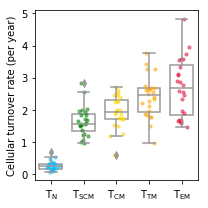

In [12]:
#get turnover rate and plot

#get turnover rate and plot
rate_df = long_df[~np.isnan(long_df['cellular_hl_days'])]
PIDS=rate_df['pat_id'].unique()

turnrate_l=[]
for pind,p in enumerate(PIDS):
    tdf=rate_df[rate_df['pat_id']==p]
    turnrate = np.log(2)/tdf['cellular_hl_days'].unique()*365
    turnrate_l.append([p]+list(turnrate))
aL_df = pd.DataFrame(turnrate_l,columns=['pid']+celltypes)

plt.figure(figsize=(3,3))
#sns.boxplot(-aL_df[celltypes],palette=dict(zip(celltypes,cellcolors)),vert=True)
for i in range(5):
    plt.scatter(np.random.normal(i,jit,len(aL_df)),aL_df[celltypes[i]],s=10,color=cellcolors[i],alpha=0.5)
    #print(st.ttest_1samp(-aL_df[celltypes[i]],popmean=0))
sns.boxplot(aL_df[celltypes],width=0.7,color='white')
plt.xticks(range(5),cellnames)
plt.ylabel('Cellular turnover rate (per year)')
#plt.axhline(0,color='k',alpha=0.8)

#plt.ylim([-5,5])
plt.tight_layout()

plt.savefig('figures/turnover_rates2.pdf',dpi=600)


In [22]:
np.log(2)/np.median(aL_df,axis=0)[1:]*12

array([34.7987212 ,  5.31075024,  4.28906782,  3.39905327,  3.10080793])

In [33]:
for i in range(4):
    print(st.ttest_ind(aL_df[celltypes[i]],aL_df[celltypes[i+1]],equal_var=False))


Ttest_indResult(statistic=-14.056953065728488, pvalue=4.440900076148696e-14)
Ttest_indResult(statistic=-2.171891304116602, pvalue=0.03511048777598244)
Ttest_indResult(statistic=-2.842048562619413, pvalue=0.006793893979337312)
Ttest_indResult(statistic=-1.2747618296803005, pvalue=0.20948385696168503)


In [34]:
#this is the ratio of subset decay rate to cell turnover rate
#gets at the question, what fraction of subset decay 

#dfx = rfx * fx
#rfx = replace - turnover
#replace = rfx + turnover

#fraction replaced = replace rate / turnover rate

fX_l=[]
for p in list(aL_df['pid']):
    tX = aL_df[aL_df['pid']==p][celltypes].values[0] #cell turnover rate
    mX = param_df[param_df['id']==p][monolix_param_names].values[0] #subset HIV DNA decay rate

    fX_l.append((mX+tX)*100/tX)
fxdf=pd.DataFrame(np.array(fX_l),columns=celltypes)


Ttest_1sampResult(statistic=0.030279112692937368, pvalue=0.976105670102198)
112.4699144506441
Ttest_1sampResult(statistic=-2.123365421946857, pvalue=0.0446981277643993)
93.79289316567919
Ttest_1sampResult(statistic=0.6010527364135074, pvalue=0.5536828853182348)
99.17868675004672
Ttest_1sampResult(statistic=-5.640228986597346, pvalue=9.670828418311574e-06)
96.33408206656296
Ttest_1sampResult(statistic=-6.855436664831701, pvalue=5.447120546689077e-07)
93.88387800353811


/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


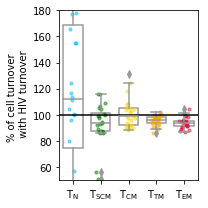

In [61]:
#dots version2

plt.figure(figsize=(3,3))
for i in range(5):
    plt.scatter(np.random.normal(i,jit,len(fxdf)),fxdf[celltypes[i]],s=10,color=cellcolors[i],alpha=0.5)
    print(st.ttest_1samp(fxdf[celltypes[i]],popmean=100))
    print(np.median(fxdf[celltypes[i]]))
sns.boxplot(fxdf[celltypes],width=0.7,color='white')
plt.xticks(range(5),cellnames)
plt.ylabel('% of cell turnover \n with HIV turnover')
plt.ylim([50,180])
#plt.axhline(100,)
plt.axhline(100,ls='-',color='k')
plt.tight_layout()
plt.savefig('figures/turnover_HIVfraction2.pdf',dpi=600)



/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


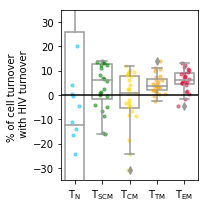

In [50]:
#dots version2

plt.figure(figsize=(3,3))
for i in range(5):
    plt.scatter(np.random.normal(i,jit,len(fxdf)),100-fxdf[celltypes[i]],s=10,color=cellcolors[i],alpha=0.5)
sns.boxplot(100-fxdf[celltypes],width=0.7,color='white')
plt.xticks(range(5),cellnames)
plt.ylabel('% of cell turnover \n with HIV turnover')
plt.ylim([-35,35])
plt.axhline(0,ls='-',color='black')
plt.tight_layout()
plt.savefig('figures/turnover_HIVfraction3.pdf',dpi=600)



In [35]:
np.mean(fxdf)

TN      100.721681
TSCM     93.411251
TCM     101.354459
TTM      95.454158
TEM      93.888093
dtype: float64

In [36]:
np.std(fxdf)

TN      114.305254
TSCM     14.881343
TCM      10.807304
TTM       3.865285
TEM       4.275683
dtype: float64

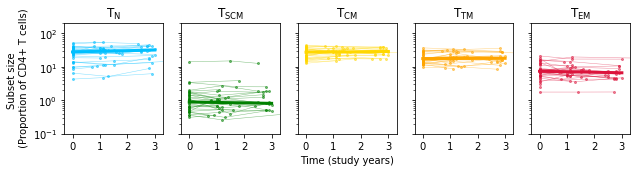

In [42]:
Sx_df=pd.read_csv('data/long_df_Sx.csv')

#info for monolix model
param_df=pd.read_csv('../monolix2/SX_1nodiff/IndividualParameters/estimatedIndividualParameters.txt')
param_df.head()

#plot all subset data relative to study initiation

fig,axarr=plt.subplots(1,5,figsize=(9,2.5),sharex=True,sharey=True)
sim_t = np.linspace(0,3,100)
for ic,ct in enumerate(celltypes):
    ax=axarr[ic]
    for ip,p in enumerate(Sx_df['pat_id'].unique()):
        tdf=Sx_df[(Sx_df['pat_id']==p) & (Sx_df['celltype']==ct)]
        ax.semilogy(tdf['time_postART_years']-tdf['time_postART_years'].iloc[0],tdf['subsetpropSx'],
                    ls='-',marker='o',lw=0.5,markersize=2,alpha=0.5,color=cellcolors[ic])#cz_list[pind])

    avgT0 = np.median(param_df['T'+str(ic+1)+'0_mode'])
    avg_k = np.median(param_df['th'+str(ic+1)+'_mode'])
    ax.plot(sim_t,avgT0*np.exp(avg_k*sim_t),lw=3,color=cellcolors[ic])
        
    ax.set_title(cellnames[ic])

axarr[2].set_xlabel('Time (study years)')
axarr[0].set_ylabel('Subset size \n (Proportion of CD4+ T cells)')
axarr[0].set_xticks(range(5))
axarr[0].set_xlim([-0.3,3.3])
axarr[0].set_ylim([0.1,200])

plt.tight_layout()    
plt.savefig('figures/Sx_studyyears.pdf',dpi=600)

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


Ttest_1sampResult(statistic=19.928190308584284, pvalue=4.930056693904146e-21)
Ttest_1sampResult(statistic=-40.013692633145595, pvalue=1.929555690771143e-31)
Ttest_1sampResult(statistic=6.794334479135712, pvalue=6.119564321472725e-08)
Ttest_1sampResult(statistic=11.517901827660928, pvalue=1.250228426806208e-13)
Ttest_1sampResult(statistic=-16.26215792142283, pvalue=3.633178798579569e-18)


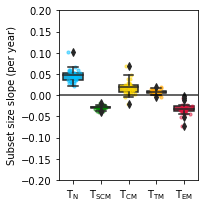

In [43]:
#look at net clearance rates
plt.figure(figsize=(3,3))
sns.boxplot(param_df[monolix_param_names],width=0.7,
               palette=dict(zip(monolix_param_names,cellcolors)))
for i in range(5):
    plt.scatter(np.random.normal(i,jit,len(param_df)),param_df[monolix_param_names[i]],s=10,color=cellcolors[i],alpha=0.5)
    print(st.ttest_1samp(param_df[monolix_param_names[i]],popmean=0))
plt.axhline(0,color='k',alpha=0.8)
#plt.axhline(-0.2,color='gray',ls='--',alpha=0.5)
plt.xlim([-.5,4.5])
plt.xticks(range(5),cellnames)
#plt.xticks(range(1,7),celltypes)
plt.ylabel('Subset size slope (per year)')
plt.ylim([-0.2,0.2])
plt.tight_layout()

plt.savefig('figures/Sx_rates_box2.pdf',dpi=600)


In [39]:
#look at average half life in months, negative means growing!
-np.log(2)/param_df[monolix_param_names].median()*12

th1_SAEM   -178.276303
th2_SAEM    294.198842
th3_SAEM   -424.042648
th4_SAEM   -967.888896
th5_SAEM    255.538131
dtype: float64